### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Loading and preparing the Dataset

In [2]:
import pandas as pd
df_medical = pd.read_csv("https://raw.githubusercontent.com/Saloni-glit/Medical-dataset/main/mtsamples.csv")
df_medical.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
df_medical.shape

(4999, 6)

### Using Transcription column and keywords column

In [ ]:
df_medical = df_medical.loc[:,["transcription", "keywords"]]
df_medical

### Let us look at the nulls in the DataFrame

In [ ]:
df_medical.isnull().sum()

transcription      33
keywords         1068
dtype: int64

### Removing Null values from the data

In [ ]:
df_medical = df_medical[~(df_medical['transcription'].isnull()) &
                        ~(df_medical['keywords'].isnull()) ]

df_medical.shape

(3898, 2)

### Let us see the length of input and output

<ipython-input-8-8ab7d645bf90>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transcription)


<Axes: xlabel='transcription', ylabel='Density'>

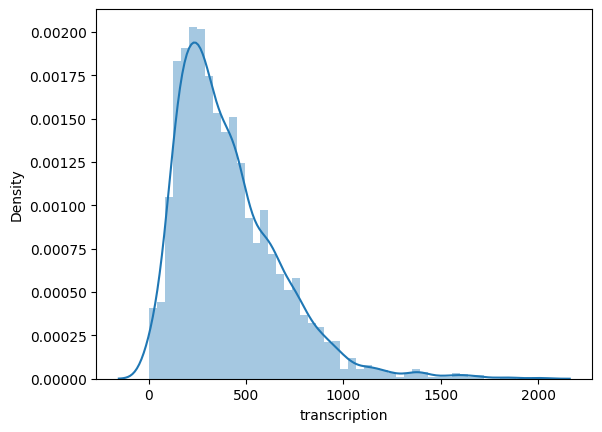

In [ ]:
transcription = df_medical['transcription'].apply(lambda x: len(x.split()))
sns.distplot(transcription)

##### Fixing Input Length to 750 tokens with Padding and truncation

<ipython-input-9-4787efb74e39>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(keywords)


<Axes: xlabel='keywords', ylabel='Density'>

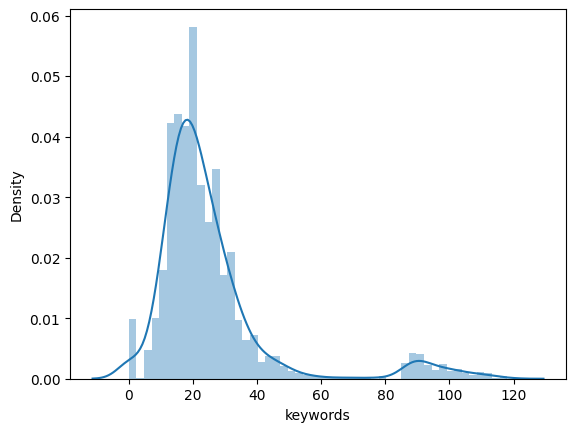

In [ ]:
keywords = df_medical['keywords'].apply(lambda x: len(x.split()))

sns.distplot(keywords)

### Let us use at most 100 keywords

In [ ]:
np.quantile(transcription,0.95)

894.0

In [ ]:
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4984,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr..."
4985,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem..."
4989,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
4993,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."


!pip install accelerate bitsandbytes

This command installs the accelerate and bitsandbytes libraries. These libraries are used for efficient distributed training and mixed-precision training, respectively.

Then we load the BART model for conditional generation from the Hugging Face model hub. The tokenizer is configured with padding on the left and truncation on the right.  the model is loaded onto the GPU.

In [ ]:
!pip install accelerate bitsandbytes
from transformers import BartForConditionalGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left",
                                         truncation_side='right')

if torch.cuda.is_available():
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda")
                                                     # load_in_8bit=True)
else:
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

### For a pytorch model we need a DataLoader so implementing a Dataloader

The `MedicalKeywordDataset` class is a PyTorch dataset designed for handling medical text data with associated keywords. It facilitates the creation of training and testing datasets for machine learning tasks, specifically for keyword extraction.

## Class Initialization

### Parameters:
- `df`: Pandas DataFrame containing the medical data.
- `transcript`: Column name representing the medical transcriptions.
- `keywords`: Column name representing the associated keywords.
- `tokenizer`: Tokenizer for encoding text data.
- `in_len`: Maximum length of the input transcriptions.
- `out_len`: Maximum length of the output keywords.

transcript_tokens: Tensor containing encoded transcript tokens.             
keyword_tokens: Tensor containing encoded keyword tokens.

batch_size: Number of samples in each batch.       
shuffle: If True, the dataset will be shuffled during each epoch.


In [ ]:
class MedicalKeywordDataset(Dataset):
    def __init__(self, df, transcript, keywords, tokenizer, in_len, out_len):
        self.df = df
        self.transcript = transcript
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.in_len = in_len
        self.out_len = out_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        #print(self.df[self.transcript].iloc[idx])
        transcript_tokens = self.tokenizer(self.df[self.transcript].iloc[idx],
                                          padding='max_length',
                                          truncation=True,
                                          max_length=self.in_len,
                                          return_tensors='pt'
                                          )['input_ids']

        keyword_tokens = self.tokenizer(self.df[self.keywords].iloc[idx],
                                       padding="max_length", truncation=True,
                                       max_length=self.out_len,
                                       return_tensors='pt')['input_ids']

        ### Moving the tensors to GPU
        if torch.cuda.is_available():
            transcript_tokens = transcript_tokens.to("cuda")
            keyword_tokens = keyword_tokens.to("cuda")
        #print(transcript_tokens)
        return transcript_tokens[0,:], keyword_tokens[0,:]




from sklearn.model_selection import train_test_split

### Splitting the data to train and test sets
df_train, df_test = train_test_split(df_medical, train_size=0.9, random_state=34)


ds_train = MedicalKeywordDataset(df_train,'transcription','keywords',tokenizer,
                            750, 100)

ds_test = MedicalKeywordDataset(df_test,'transcription','keywords',tokenizer,
                            750, 100)


### Converting dataset object to dataloader object
batch_size = 6

### Conversion
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

### Now let us write the train and validation functions

### Optimizer Initialization

The Adam optimizer is used for training the model. It is initialized with a learning rate of 2e-4.




In [ ]:
### Optimizer Adam used here
optimizer = Adam(model.parameters(),lr=2e-4)

### Defining Epochs
epochs = 3

def num_batches(total, batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1


### Number of batches defined for a dataset
train_batches = num_batches(df_train.shape[0],batch_size)
test_batches = num_batches(df_test.shape[0],batch_size)


### Function to train model
def train(data,num_batches, model, optimizer):
    model.train()
    model_loss = 0
    model_acc = 0
    i = 0
    for tr, kw in data:
        optimizer.zero_grad()
        #print(kw.shape)
        ### Feed forward Pass
        out = model(tr, labels=kw)

        ### Loss computation
        r_loss = out.loss
        model_loss += r_loss.item()

        ### Accuracy Computation
        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(kw == preds).item()/(kw.shape[0]*kw.shape[1])
        model_acc += acc

        ### Backpropogation
        r_loss.backward()
        optimizer.step()

        i+=1
        print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\r")

    print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\n")


def test(data,num_batches, model):
    model.eval()
    model_loss = 0
    model_acc = 0
    i = 0
    for tr, kw in data:
        #optimzer.zero_grad()

        ### Feed forward Pass
        out = model(tr, labels=kw)

        ### Loss computation
        r_loss = out.loss
        model_loss += r_loss.item()

        ### Accuracy Computation
        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(kw == preds).item()/(kw.shape[0]*kw.shape[1])
        model_acc += acc

#         ### No Backpropogation as it is evaluation of model
#         r_loss.backward()
#         optimizer.step()

        i+=1
        print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\r")

    print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\n")

#LOSS AND ACCURACY FOR 6 BATCHES

In [ ]:
for e in range(epochs):
    train(dl_train,train_batches,model, optimizer)
    test(dl_test, test_batches,model)

[==================================================>]loss=1.2526252045590653 accuracy=0.7910341880341879
[==================================================>]loss=0.821370669053151 accuracy=0.8374358974358975
[==================================================>]loss=0.8278429380339435 accuracy=0.8339529914529924
[==================================================>]loss=0.7264863743231846 accuracy=0.8476153846153847
[==================================================>]loss=0.6506133498799088 accuracy=0.8543475783475781
[==================================================>]loss=0.6381889700889587 accuracy=0.8593589743589746


In [ ]:
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4984,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr..."
4985,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem..."
4989,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
4993,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."


### Let us compare the predictions from the test data

The generate_keywords function is designed to generate keywords for transcriptions using a pre-trained language model. Below is the detailed documentation for the function:

Input Parameters:
df: Pandas DataFrame containing the transcriptions.
transcription: Name of the column in the DataFrame containing the transcriptions.
model: Pre-trained language model capable of keyword generation.
tokenizer: Tokenizer used to tokenize the input transcriptions.
Output:
The function returns a modified DataFrame (df) with an additional column named 'Result' containing the generated keywords.

Tokenization and Preprocessing:

Tokenizes the transcriptions using the provided tokenizer.
Converts the input transcriptions to PyTorch tensors.
Optionally moves the tensors to the GPU if available.

Model Inference and Decoding:

Uses the pre-trained language model to generate keywords.
Specifies the minimum and maximum length constraints for the generated keywords.

Decoding and Post-processing:

Decodes the generated token IDs into human-readable keywords using the tokenizer.
Removes special tokens from the decoded keywords.

In [ ]:
def generate_keywords(df,transcription, model, tokenizer):
    df['Result'] = df[transcription].apply(lambda x: tokenizer(x, max_length=750,
    padding='max_length', truncation=True, return_tensors='pt')['input_ids'])
    if torch.cuda.is_available():
        df['Result'] = df['Result'].apply(lambda x: x.to("cuda"))

    df['Result'] = df['Result'].apply(lambda x: model.generate(x,
                                                    min_length=20,
                                                    max_length=100 ))
    df['Result'] = df['Result'].apply(lambda x: tokenizer.batch_decode(x,
                                                    skip_special_tokens=True))
    return df




In [ ]:
df_res = generate_keywords(df_test,'transcription',model,tokenizer)

The model.generate method is used to generate sequences of tokens from a given input sequence using a pre-trained language model. Below is the detailed documentation for the method:

Input Parameters:
input_ids: PyTorch tensor representing the input sequence. It contains token IDs.
max_length: Maximum length of the generated sequence. If specified, it constrains the maximum number of tokens in the output sequence.

Output:
The method returns a PyTorch tensor containing the generated token IDs for the sequence.

In [ ]:
model.generate(tokenizer(df_test['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True,
                        return_tensors='pt')['input_ids'].to('cuda'),max_length=100)

tensor([[    2,     0, 12557, 21712,     6,  7843, 12921,   991, 11418,  5000,
             6, 41834,  8421, 18592, 35231, 10373, 26574,     6, 34988,  8421,
             6, 11720, 34831,   415,  4399,     6,  2295, 33718,  5206,     6,
         18592, 35231, 36119,     6,  5494,  6204, 36119,     6,  8869,   740,
            90, 26574,     6,  2295,  6168, 29609, 35453,   681,  4758,   271,
          7257,     6,  2295,  3156,     6,  8869, 26574,     6, 26574,     6,
         10373, 26574,  1258,     6,  2295,     6,  2295, 46599,     6,    35,
            20,  8738, 28584, 38131,  1131, 37118,  7728,   690,     8,  7721,
            32,  1286,    30,  1337,  1434,     8,  1322,    13,  5135,  3508,
           129,     4,   256,  3732,   523,   642, 18997,   473,    45,     2]],
       device='cuda:0')

###Documentation for tokenizer Method
The tokenizer method is used to tokenize a text sequence using a pre-trained tokenizer. Below is the detailed documentation for the method:

Input Parameters:
text: Input text sequence that needs to be tokenized.

max_length : Maximum length of the tokenized sequence. If specified, it constrains the maximum number of tokens in the output sequence.
padding : Specifies the padding strategy. If specified, it pads the sequences to the maximum length.
truncation : Specifies whether to truncate the sequences to the maximum length if they exceed it.

Output:
The method returns a dictionary containing tokenized information, including:

input_ids: Token IDs representing the input sequence.
attention_mask: Attention mask indicating which tokens should be attended to.

In [ ]:
tokenizer(df_test['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True)

{'input_ids': [0, 47217, 3850, 3243, 39658, 6034, 35, 2156, 4129, 12921, 991, 11418, 5000, 19, 41834, 8421, 18592, 35231, 10373, 26574, 11, 5, 235, 2295, 482, 13796, 2371, 6034, 5089, 31987, 534, 22570, 35, 2156, 20, 3186, 16, 10, 974, 12, 180, 12, 279, 2943, 54, 5232, 41, 490, 7183, 1356, 25, 10, 920, 4, 1437, 91, 8960, 2226, 10, 5494, 6204, 36119, 11, 4013, 8, 122, 34, 35453, 681, 11, 5, 34988, 8421, 9, 5, 235, 2295, 25, 157, 25, 10, 19790, 4758, 271, 7257, 4, 1437, 91, 16, 11793, 35453, 681, 7129, 25, 157, 25, 36099, 4758, 271, 7257, 23226, 19, 10373, 26574, 11, 5, 235, 2295, 482, 43869, 5733, 211, 2889, 17567, 3196, 1729, 46686, 134, 4, 1437, 7298, 9, 490, 7183, 7, 5, 235, 2295, 482, 176, 4, 1437, 7298, 9, 5494, 6204, 36119, 2194, 618, 5989, 11, 5, 235, 2295, 482, 246, 4, 1437, 8897, 44327, 681, 11, 34988, 8421, 482, 306, 4, 1437, 211, 9401, 35453, 681, 4758, 271, 7257, 11, 5, 235, 2295, 33718, 5206, 5, 1217, 9, 5, 41834, 9438, 482, 47060, 5733, 211, 2889, 17567, 3196, 1729, 46686,

In [ ]:
df_res['Result'] = df_res['Result'].apply(lambda x: x[0])

# RESULTS

In [ ]:
print(df_res['keywords'].iloc[0])
print(df_res['Result'].iloc[0])

surgery, phacoemulsification, intraocular lens implant, posterior chamber, chamber, eye, intraocular, lens,
surgery, phacoemulsification, posterior chamber intraocular lens implant, anterior chamber, diamond keratome, eye obscuring, intraocular detachment, retinal detachment, wire ct implant, eye oblique silicone oil cataract, eye images, wire implant, implant, lens implantation, eye, eyeNOTE,: Thesetranscribed medical transcription sample reports and examples are provided by various users andare for reference purpose only. MTHelpLine does not


In [ ]:
df_res

,transcription,keywords,Result
436,"TITLE OF OPERATION: , Phacoemulsification with...","surgery, phacoemulsification, intraocular lens...","surgery, phacoemulsification, posterior chambe..."
2584,"PROCEDURE: , Laparoscopy with ablation of endo...","obstetrics / gynecology, ablation of endometri...","obstetrics / gynecology, ablation, laparoscopy..."
2486,"CHILD PHYSICAL EXAMINATION,VITAL SIGNS: Birth...","office notes, child physical examination, phys...","obstetrics / gynecology, child physical exam, ..."
1112,"PREOPERATIVE DIAGNOSES:,1. Ischemic cardiomyo...","surgery, cardiomyopathy, ioban, ischemic, isch...","cardiovascular / pulmonary, cardiomyopathy, ca..."
1630,"EXAM: , Five views of the right knee.,HISTORY:...","radiology, fractures dislocations or subluxati...","orthopedic, patella alta, growth arrest lines,..."
...,...,...,...
495,"PREOPERATIVE DIAGNOSES:,1. Displaced intraart...","surgery, intraarticular fracture, esmarch, k-w...","orthopedic, intraarticular fracture, carpal tu..."
189,"PREOPERATIVE DIAGNOSES: , Epiretinal membrane,...","surgery, epiretinal membrane, pars plana vitre...","surgery, epiretinal membrane, membrane peel, i..."
1756,"DESCRIPTION:,1. Normal cardiac chambers size....","radiology, ejection fraction, lv systolic func...","cardiovascular / pulmonary, ejection fraction,..."
4227,"VITAL SIGNS:, Reveal a blood pressure of *, t...","consult - history and phy., jugular venous dis...","consult - history and phy., gafra Coma scale, ..."


No charts were generated by quickchart


### Looking at top 5

In [ ]:
for i in range(5):

    print(f"-----------------Row no {i+1}------------------")
    print("Transcription:")
    print(df_res['transcription'].iloc[i])
    print("\n")
    print("Keywords:")
    print(df_res['keywords'].iloc[i])
    print("\n")
    print("Result:")
    print(df_res['Result'].iloc[i])
    print("\n"*3)

-----------------Row no 1------------------
Transcription:
TITLE OF OPERATION: , Phacoemulsification with posterior chamber intraocular lens implant in the right eye.,INDICATION FOR SURGERY: , The patient is a 27-year-old male who sustained an open globe injury as a child.  He subsequently developed a retinal detachment in 2005 and now has silicone oil in the anterior chamber of the right eye as well as a dense cataract.  He is undergoing silicone oil removal as well as concurrent cataract extraction with lens implant in the right eye.,PREOP DIAGNOSIS:,1.  History of open globe to the right eye.,2.  History of retinal detachment status post repair in the right eye.,3.  Silicone oil in anterior chamber.,4.  Dense silicone oil cataract in the right eye obscuring the view of the posterior pole.,POSTOP DIAGNOSIS:,1.  History of open globe to the right eye.,2.  History of retinal detachment status post repair in the right eye.,3.  Silicone oil in anterior chamber.,4.  Dense silicone oil cat